In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import imageio
import utm
import numpy as np
import numpy.ma as ma
from tqdm.auto import tqdm
from concurrent.futures import ProcessPoolExecutor
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd 
import geopandas as gpd
import rasterio

from eolearn.core import FeatureType, LinearWorkflow, EOExecutor, EOTask, EOPatch, SaveTask, LoadTask, OverwritePermission, ExtractBandsTask, RemoveFeature
from eolearn.mask import AddValidDataMaskTask, AddMultiCloudMaskTask
from eolearn.io import SentinelHubInputTask, ExportToTiff
from eolearn.coregistration import ThunderRegistration
from eolearn.features import NormalizedDifferenceIndexTask, SimpleFilterTask

from sentinelhub import DataSource, BBox, CRS, UtmZoneSplitter


from skimage.morphology import disk, binary_dilation
from skimage.filters import threshold_otsu, gaussian
from skimage.feature import canny

/home/ubuntu/.pyenv/versions/3.7.6/envs/base/lib/python3.7/site-packages/bolt/utils.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/home/ubuntu/.pyenv/versions/3.7.6/envs/base/lib/python3.7/site-packages/bolt/factory.py:17: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args = inspect.getargspec(func)


# Task definitions

In [3]:
class ValidData:
    def __init__(self, is_data_mask, clm_mask):
        self.is_data_mask = is_data_mask
        self.clm_mask = clm_mask
        
    def __call__(self, eopatch):
        return np.logical_and(eopatch.mask[self.is_data_mask].astype(np.bool),
                              np.logical_not(eopatch.mask[self.clm_mask].astype(np.bool)))
    

class ValidCoverageTask(EOTask):
    def __init__(self, feature_in, feature_out):
        self.feature_in = feature_in
        self.feature_out = feature_out
        
    def execute(self, eopatch):
        mask = eopatch[self.feature_in]
        coverage = np.count_nonzero(mask == 1, axis=(1,2))/np.prod(mask.shape[1:])
        eopatch[self.feature_out] = coverage
        return eopatch
    
    
class WaterDetector(EOTask):
    def __init__(self, feature_in, feature_out):
        self.feature_in = feature_in
        self.feature_out = feature_out
        
    def execute(self, eopatch):
        ndwi = eopatch.data['NDWI'][...,-1]
        wmask = []
        for im in ndwi:
            im = gaussian(im, 2)
            try:
                _, mask = get_water_mask_from_S2(im)
                wm = np.count_nonzero(mask == 1, axis=(0,1))/np.prod(mask.shape)        
            except:
                wm = np.nan
            wmask.append(wm)
        eopatch[self.feature_out] = np.expand_dims(wmask, -1)
        return eopatch
    
    
def get_water_mask_from_S2(ndwi, canny_sigma=4, canny_threshold=0.3, selem=disk(4)):
    """
    Make water detection on input NDWI single band image.
    
    """
    # default threshold (no water detected)
    otsu_thr = 1.0
    status = 0
    
    # transform NDWI values to [0,1]
    ndwi_std = (ndwi - np.min(ndwi))/np.ptp(ndwi)
    
    if len(np.unique(ndwi)) > 1:
        edges = canny(ndwi_std, sigma=canny_sigma, high_threshold=canny_threshold)
        edges = binary_dilation(edges, selem)
        ndwi_masked = ma.masked_array(ndwi, mask=np.logical_not(edges))
        
        if len(np.unique(ndwi_masked.data[~ndwi_masked.mask])) > 1:
            # threshold determined using dilated canny edge + otsu
            otsu_thr = threshold_otsu(ndwi_masked.data[~ndwi_masked.mask])
            status = 1

            # if majority of pixels above threshold have negative NDWI values
            # change the threshold to 0.0
            fraction = np.count_nonzero(ndwi>0)/np.count_nonzero(ndwi>otsu_thr)
            if fraction < 0.9:
                otsu_thr = 0.0
                status = 3
        else:
            # theshold determined with otsu on entire image
            otsu_thr = threshold_otsu(ndwi)
            status = 2
            
            # if majority of pixels above threshold have negative NDWI values
            # change the threshold to 0.0
            fraction = np.count_nonzero(ndwi>0)/np.count_nonzero(ndwi>otsu_thr)
            if fraction < 0.9:
                otsu_thr = 0.0
                status = 4

    return status, (ndwi>otsu_thr).astype(np.uint8)

def get_water_cov(ndwi):
    _, mask = get_water_mask_from_S2(ndwi)
    return np.count_nonzero(mask == 1, axis=(0,1))/np.prod(mask.shape)

In [4]:
#(lat, lon), width in meters
location_data = [[48.6093, -1.6685], 15000]
factors = [2.5]
th = 0.95

time_interval = [datetime(2017,1,1), datetime(2020,5,22)]

x,y,zone,letter = utm.from_latlon(*location_data[0])
x,y = np.round([x,y], -1)
d = location_data[1]
bbox = BBox((x-d, y-d, x+d, y+d), eval(f'CRS.UTM_{zone}{"N" if letter >= "N" else "S"}')).geometry
crs = eval(f'CRS.UTM_{zone}{"N" if letter >= "N" else "S"}')

utm_splitter = UtmZoneSplitter([bbox], crs, 4400)
bbox_list = utm_splitter.get_bbox_list()

gdf = gpd.GeoDataFrame(None, geometry=[b.geometry for b in bbox_list], crs=crs.epsg)

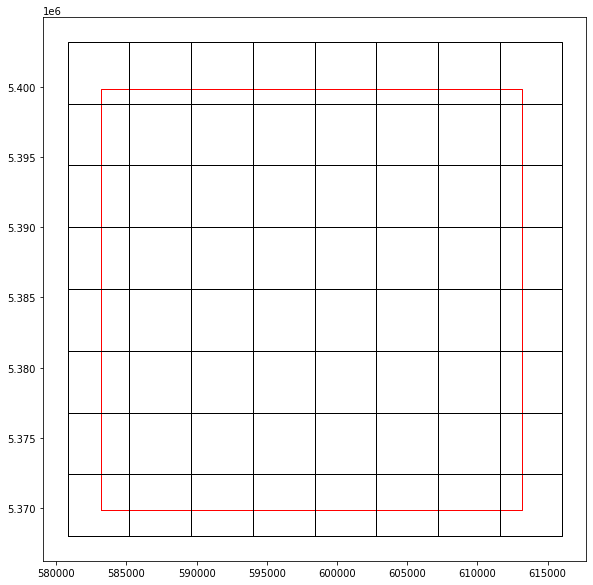

In [5]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
gpd.GeoDataFrame(None, geometry=[bbox], crs=crs.epsg).plot(ax=ax, color='None', edgecolor='r')
gdf.plot(ax=ax, color='None', edgecolor='k')

# Download

In [6]:
class ValidDataFractionPredicate:
    """ Predicate that defines if a frame from EOPatch's time-series is valid or not. Frame is valid, if the 
    valid data fraction is above the specified threshold.
    """
    def __init__(self, threshold):
        self.threshold = threshold
        
    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8)) / np.prod(array.shape)
        return coverage > self.threshold

download_task = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, 'BANDS-S2-L1C'),
    resolution=10,
    maxcc=1.0,
    time_difference=timedelta(hours=2),
    data_source=DataSource.SENTINEL2_L1C,
    additional_data=[
        (FeatureType.MASK, 'dataMask')
    ],
    max_threads=15
)

# task for calculating clouds masks
add_clm_task = AddMultiCloudMaskTask(
    processing_resolution=120,
    mask_feature='CLM_C',
    is_data_feature = 'dataMask',
    average_over=16,
    dilation_size=8
)

valid_data_task = AddValidDataMaskTask(ValidData(is_data_mask='dataMask', clm_mask='CLM_C'), 'VALID_DATA')
valid_data_predicate = ValidDataFractionPredicate(0.95)
filter_task = SimpleFilterTask((FeatureType.MASK, 'VALID_DATA'), valid_data_predicate)

ndwi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS-S2-L1C'), (FeatureType.DATA, 'NDWI'), bands=[2,7])
ndwi_surf = WaterDetector((FeatureType.DATA, 'NDWI'), (FeatureType.SCALAR, 'NDWI_SURF'))

extract_bands = ExtractBandsTask((FeatureType.DATA, 'BANDS-S2-L1C'), (FeatureType.DATA, 'RGB'), [3,2,1])
remove_task = RemoveFeature([(FeatureType.DATA, 'BANDS-S2-L1C')])

# Download

# Load

In [6]:
# tasks for loading and saving
load_task = LoadTask('./eopatches', lazy_loading=True)

# load the previously created eopatches
workflow = LinearWorkflow(
    load_task    
)

execution_args = []
for idx, bbox in enumerate(bbox_list):
    execution_args.append({
        load_task: {'eopatch_folder': f'eopatch_{idx}'}
    })
    
eopatches = []
for args in execution_args:
    eopatches.append(workflow.execute(args).eopatch())

In [7]:
sets = [set([ts.date() for ts in eop.timestamp]) for eop in eopatches]

In [8]:
dt_list = sets[0]
for i in range(1,len(sets)):
    dt_list = dt_list.intersection(sets[i])
dt_list = np.array(list(dt_list))
dt_list = np.sort(dt_list)

In [11]:
np.array([dt.isoformat() for dt in dt_list])

array(['2017-06-21', '2017-07-06', '2018-02-21', '2018-02-26',
       '2018-04-22', '2018-05-07', '2018-06-26', '2018-08-05',
       '2018-10-04', '2018-10-09', '2018-11-18', '2019-02-26',
       '2019-06-26', '2019-07-06', '2019-09-19', '2019-12-03',
       '2020-01-22', '2020-02-06', '2020-03-17', '2020-04-01'],
      dtype='<U10')

### export

In [12]:
for idx, eop in tqdm(enumerate(eopatches), total=len(eopatches)):
    for jdx, dt in enumerate(dt_list):
        date_id = np.where(np.array([ts.date() for ts in eop.timestamp]) == dt)[0][0]
        export_task = ExportToTiff((FeatureType.DATA, 'RGB'), date_indices = [int(date_id)], crs=crs)
        export_task(eop, filename=f'tiffs/rgb/eopatch_{idx}_{jdx}.tiff')

In [13]:
for idx, eop in tqdm(enumerate(eopatches), total=len(eopatches)):
    for jdx, dt in enumerate(dt_list):
        date_id = np.where(np.array([ts.date() for ts in eop.timestamp]) == dt)[0][0]
        export_task = ExportToTiff((FeatureType.DATA, 'NDWI'), date_indices = [int(date_id)], crs=crs)
        export_task(eop, filename=f'tiffs/ndwi/eopatch_{idx}_{jdx}.tiff')

### merge

In [14]:
os.system(f'rm -rf tiffs/rgb/rgb_*.tiff')

for idx in tqdm(range(len(dt_list)), total=len(dt_list)):
    os.system(f'gdal_merge.py -co compress=lzw -o tiffs/rgb/rgb_{idx}.tiff tiffs/rgb/eopatch_*_{idx}.tiff')

In [15]:
os.system(f'rm -rf tiffs/ndwi/ndwi_*.tiff')

for idx in tqdm(range(len(dt_list)), total=len(dt_list)):
    os.system(f'gdal_merge.py -co compress=lzw -o tiffs/ndwi/ndwi_{idx}.tiff tiffs/ndwi/eopatch_*_{idx}.tiff')

### water cov

In [11]:
rgb = []
for idx in tqdm(range(len(dt_list)), total=len(dt_list)):
    f = rasterio.open(f'./tiffs/rgb/rgb_{idx}.tiff')
    data = np.moveaxis(f.read(), 0, -1)
    rgb.append(data)
    f.close()

In [12]:
ndwi = []
for idx in tqdm(range(len(dt_list)), total=len(dt_list)):
    f = rasterio.open(f'./tiffs/ndwi/ndwi_{idx}.tiff')
    data = np.moveaxis(f.read(), 0, -1).squeeze(-1)
    ndwi.append(data)
    f.close()

In [13]:
def get_water_cov(ndwi):
    # mask = gaussian(ndwi[1000:2000, 600:1500], 5) > 0.3
    mask = gaussian(ndwi, 1) > 0.1
    return np.count_nonzero(mask)/np.prod(mask.shape)

# def get_water_cov(ndwi):
#     _, mask = get_water_mask_from_S2(ndwi[1000:2000, 600:1500])
#     return np.count_nonzero(mask == 1, axis=(0,1))/np.prod(mask.shape)

In [14]:
with ProcessPoolExecutor() as executor:
    water_cov = list(tqdm(executor.map(get_water_cov, ndwi), total=len(ndwi)))
water_cov = np.array(water_cov)

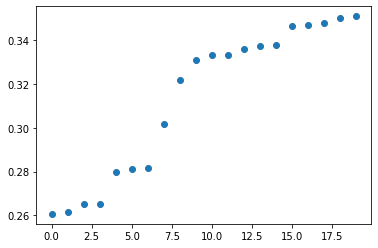

In [15]:
plt.scatter(range(len(water_cov)), np.sort(water_cov))

# Create animation

In [16]:
# final_indices = np.array(np.argsort(water_cov).tolist())# + np.argsort(water_cov).tolist()[::-1][1:])
final_indices = np.argsort(water_cov)[np.array([0,3,4,7,8,9,15,-2,-1])]
final_indices = final_indices.tolist() + final_indices[::-1][1:-1].tolist() + np.argsort(water_cov)[np.array([1])].tolist()

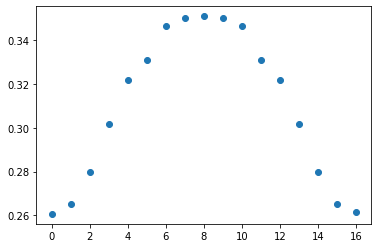

In [17]:
plt.scatter(range(len(final_indices)), water_cov[final_indices])

In [18]:
# create RGB animations 
os.system('rm -rf graphs && mkdir graphs')

def plot_image(idx):
    f = rasterio.open(f'./tiffs/rgb/rgb_{idx}.tiff')
    data = np.moveaxis(f.read(), 0, -1)
    f.close()
    fig = plt.figure(figsize=(15,15))
    plt.imshow(np.clip(data*2.8,0,1))
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.savefig(f'graphs/true_color_{idx}.png', dpi=200, bbox_inches='tight')
    plt.close()
    
with ProcessPoolExecutor() as executor:
    _ = list(tqdm(executor.map(plot_image, np.unique(final_indices)), total=len(np.unique(final_indices))))

#with imageio.get_writer(f'true_color.gif', mode='I', duration=2.5/len(final_indices)) as writer:
#    for idx in final_indices:
#        image = imageio.imread(f'graphs/true_color_{idx}.png')
#        writer.append_data(image)

In [19]:
os.system('rm -rf anim && mkdir anim')
for idx, im in enumerate(final_indices):
    os.system(f'cp graphs/true_color_{im}.png anim/true_color_{idx}.png')